## 1.Scraping Trading Ideas for NASDAQ-AAPL Stock from TradingView

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd  # Import pandas library

base_url = "https://www.tradingview.com/symbols/NASDAQ-AAPL/ideas/"
sort_option = "?sort=recent"
max_pages = 90  # Adjust the number of pages you want to scrape

data_list = []

for page in range(1, max_pages + 1):
    url = f"{base_url}page-{page}/{sort_option}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    timestamp_elements = soup.find_all("span", class_="tv-card-stats__time", attrs={"data-timestamp": True})
    a_elements = soup.find_all("a", class_="tv-widget-idea__cover-link js-widget-idea__popup")
    info_rows = soup.find_all("div", class_="tv-widget-idea__info-row")
    username_elements = soup.find_all("span", class_="tv-card-user-info__name")
    
    if not timestamp_elements or not a_elements or not info_rows or not username_elements:
        break
    
    for timestamp_element, a_element, row, username_element in zip(timestamp_elements, a_elements, info_rows, username_elements):
        timestamp = timestamp_element["data-timestamp"]
        img_element = a_element.find("img")
        alt_text = img_element["alt"]
        data_href = a_element["data-href"]
        
        label_element = row.find("span", class_="badge-PlSmolIm size-medium-PlSmolIm badge-idea-ZleujXqe type-short-ZleujXqe size-medium-ZleujXqe variant-primary-ZleujXqe with-icon-ZleujXqe tv-widget-idea__label") or \
                        row.find("span", class_="badge-PlSmolIm size-medium-PlSmolIm badge-idea-ZleujXqe type-long-ZleujXqe size-medium-ZleujXqe variant-primary-ZleujXqe with-icon-ZleujXqe tv-widget-idea__label")
        
        if label_element:
            label_text = label_element.find("span", class_="content-PlSmolIm badge-idea-content-ZleujXqe").get_text()
        else:
            label_text = "N/A"
        
        username = username_element.get_text()
        
        chart_url = f"https://www.tradingview.com{data_href}"
        response = requests.get(chart_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        description_element = soup.find("div", class_="tv-chart-view__description")
        if description_element:
            description_text = description_element.get_text()
        else:
            description_text = "Description not found on the page."
        
        data_list.append((timestamp, alt_text, label_text, description_text, username))

# Create a DataFrame from the collected data
df = pd.DataFrame(data_list, columns=["Timestamp", "Alt Text", "Label", "Description", "Username"])

# Print the DataFrame
print(df)


         Timestamp                                           Alt Text  Label  \
0     1692129257.0            AAPL: Apple -> Correction Already Over?   Long   
1     1692466537.0  AAPL: Apple a Case Study! Who Sold High Who Wi...    N/A   
2     1692314572.0                 AAPL: Target 159 in September 2023  Short   
3     1692036887.0                    AAPL: ✅APPLE LONG FROM SUPPORT🚀   Long   
4     1692322097.0  AAPL: If this does not turn out to be the top,...  Short   
...            ...                                                ...    ...   
1615  1675284476.0       AAPL: Apple - AAPL - New Position - $126.55    Long   
1616  1675257793.0            AAPL: AAPL: Some downside applicable ?   Short   
1617  1675241167.0                            META: The FAANGT stocks   Long   
1618  1675198934.0  AAPL: 🍏 Apple Inc. Resistance, New Products, N...   Long   
1619  1675180069.0   AAPL: How to Hit 624% gain on AAPL in 108  days    Long   

                                       

## 2.Data Preprocessing and adjusting Article Dates for Business Days in Stock Market 

In [2]:
# Create a DataFrame from the collected data
df = pd.DataFrame(data_list, columns=["Timestamp", "Alt Text", "Label", "Description", "Username"])

# Convert Timestamp to datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

# Assign appropriate data types to other columns
data_types = {
    "Alt Text": str,
    "Label": str,
    "Description": str,
    "Username": str
}

df = df.astype(data_types)

from pandas.tseries.offsets import BDay
df["Timestamp"]=pd.to_datetime(df["Timestamp"])
df['Date'] = df['Timestamp'].dt.date
df['Date'] = pd.to_datetime(df['Date'])

# Adjust the date to the next business day if necessary
df['Adjusted_Date'] = df['Date'].apply(lambda x: x if x.weekday() < 4 else x + BDay(1))
df[['Date','Adjusted_Date']].sort_values(by='Date')



C:\Users\Chris\AppData\Local\Temp\ipykernel_3856\2932290130.py:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")


,Date,Adjusted_Date
1619,2023-01-31,2023-01-31
1618,2023-01-31,2023-01-31
1616,2023-02-01,2023-02-01
1614,2023-02-01,2023-02-01
1617,2023-02-01,2023-02-01
...,...,...
21,2023-08-18,2023-08-21
13,2023-08-19,2023-08-21
9,2023-08-19,2023-08-21
8,2023-08-19,2023-08-21


In [3]:
df.head()

,Timestamp,Alt Text,Label,Description,Username,Date,Adjusted_Date
0,2023-08-15 19:54:40,AAPL: Apple -> Correction Already Over?,Long,"Hello Traders and Investors, \r\nmy name is Ph...",basictradingtv,2023-08-15,2023-08-15
1,2023-08-19 17:36:00,AAPL: Apple a Case Study! Who Sold High Who Wi...,N/A,"High mates, Sharing weekly Chart of American t...",AMIT-RAJAN,2023-08-19,2023-08-21
2,2023-08-17 23:23:44,AAPL: Target 159 in September 2023,Short,\n\n In my method I can...,JerryManders,2023-08-17,2023-08-17
3,2023-08-14 18:14:24,AAPL: ✅APPLE LONG FROM SUPPORT🚀,Long,\n\n\n\n\n\n✅APPLE is trading in an \r\nUptren...,ProSignalsFx,2023-08-14,2023-08-14
4,2023-08-18 01:27:28,"AAPL: If this does not turn out to be the top,...",Short,\n\n This is the last s...,MikeMM,2023-08-18,2023-08-21


## 3.Sentiment Analysis and Visualization 

In [6]:

# Use a pipeline as a high-level helper
from transformers import pipeline, BertTokenizer

pipe = pipeline("text-classification", model="ProsusAI/finbert")
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
# https://huggingface.co/ProsusAI/finbert?text=short+the+stock+now

In [5]:

def analyze_sentiment(description):
    # Tokenize the description text
    tokens = tokenizer.tokenize(description)
    
    # Account for special tokens [CLS] and [SEP]
    special_tokens_count = 2
    
    # Truncate and pad the tokenized sequence if it's longer than the model's input size
    max_seq_length = tokenizer.model_max_length - special_tokens_count
    if len(tokens) > max_seq_length:
        tokens = tokens[:max_seq_length]
    
    # Convert the tokenized sequence back to text
    processed_description = tokenizer.convert_tokens_to_string(tokens)
    
    # Perform sentiment analysis on the processed description
    result = pipe(processed_description)[0]
    sentiment_label = result['label']
    sentiment_score = result['score']
    return sentiment_label, sentiment_score

# Apply sentiment analysis function and create new columns for label and score
df[['Sentiment_Label', 'Sentiment_Score']] = df['Description'].apply(analyze_sentiment).apply(pd.Series)

print(df)

               Timestamp                                           Alt Text  \
0    2023-08-15 19:54:40            AAPL: Apple -> Correction Already Over?   
1    2023-08-19 17:36:00  AAPL: Apple a Case Study! Who Sold High Who Wi...   
2    2023-08-17 23:23:44                 AAPL: Target 159 in September 2023   
3    2023-08-14 18:14:24                    AAPL: ✅APPLE LONG FROM SUPPORT🚀   
4    2023-08-18 01:27:28  AAPL: If this does not turn out to be the top,...   
...                  ...                                                ...   
1615 2023-02-01 20:48:00       AAPL: Apple - AAPL - New Position - $126.55    
1616 2023-02-01 13:24:16            AAPL: AAPL: Some downside applicable ?    
1617 2023-02-01 08:46:56                            META: The FAANGT stocks   
1618 2023-01-31 21:02:56  AAPL: 🍏 Apple Inc. Resistance, New Products, N...   
1619 2023-01-31 15:47:12   AAPL: How to Hit 624% gain on AAPL in 108  days    

      Label                                        

In [25]:
df.groupby(['Label', 'Sentiment_Label'])['Timestamp'].count()

Label  Sentiment_Label
Long   negative            37
       neutral            235
       positive            83
N/A    negative           183
       neutral            550
       positive           115
Short  negative           149
       neutral            230
       positive            38
Name: Timestamp, dtype: int64

## 4.Visualizing Sentiment Distribution

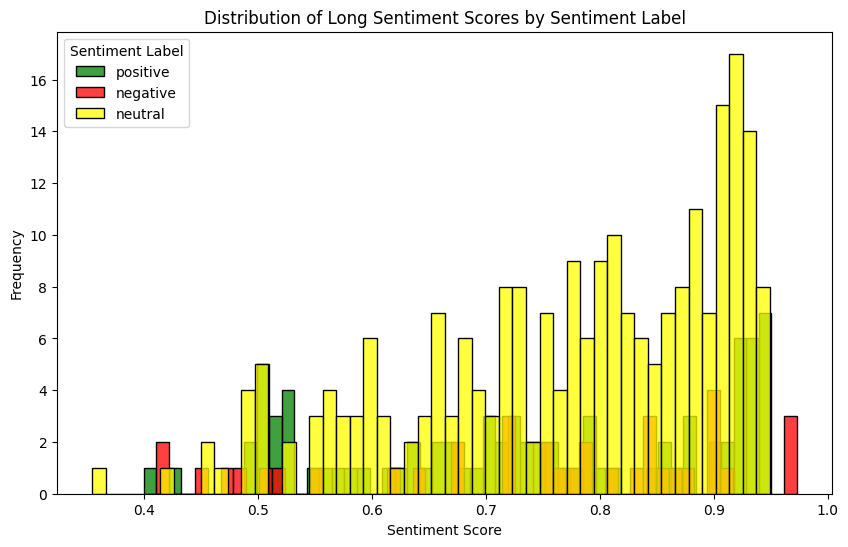

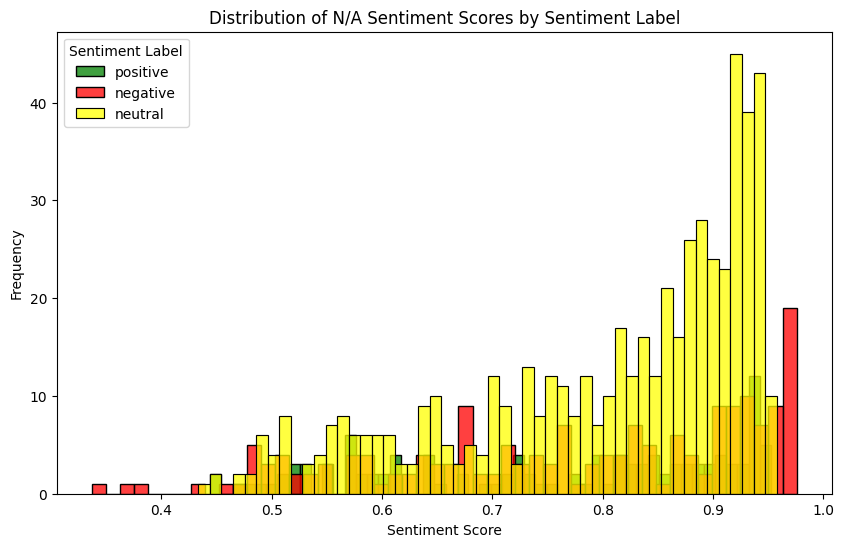

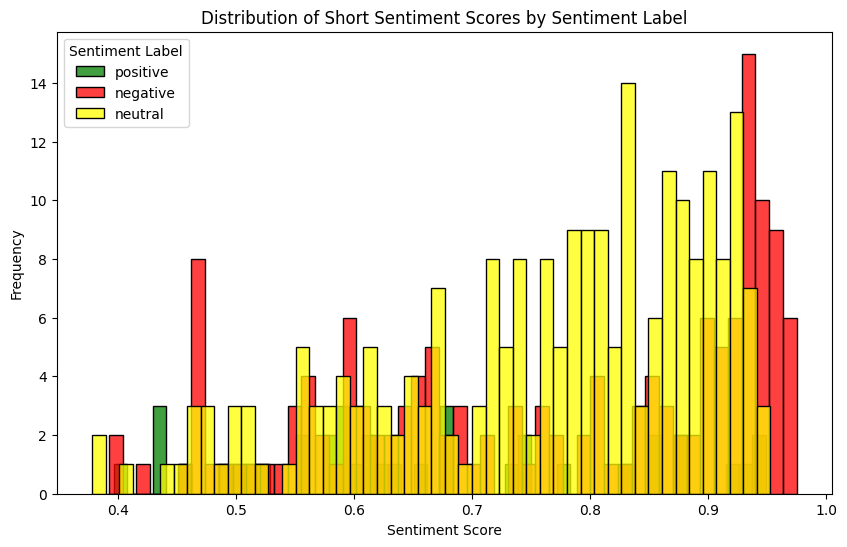

In [61]:

import seaborn as sns
import matplotlib.pyplot as plt

# Encode label values into numerical values
label_mapping = {"Long": 1, "N/A": 0, "Short": -1}
df['Label_Encoded'] = df['Label'].map(label_mapping)

# Separate the DataFrame based on 'Label'
long_df = df[df['Label'] == 'Long']
na_df = df[df['Label'] == 'N/A']
short_df = df[df['Label'] == 'Short']

long_df
grouped_long = long_df.groupby('Sentiment_Label')
grouped_na = na_df.groupby('Sentiment_Label')
grouped_short = short_df.groupby('Sentiment_Label')


# Create a mapping of Sentiment_Label values to custom legend labels
label_mapping = {
    'positive': 'Positive',
    'negative': 'Negative',
    'neutral': 'Neutral'
}

# Define a function to create and show the histogram plot
def plot_sentiment_distribution(data_df, label_mapping, sentiment_type):
    # Create a color palette for the sentiment labels
    color_palette = {'positive': 'green', 'negative': 'red', 'neutral': 'yellow'}
    
    # Create the histogram plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    for sentiment_label, color in color_palette.items():
        subset_df = data_df[data_df['Sentiment_Label'] == sentiment_label]
        sns.histplot(data=subset_df, x='Sentiment_Score', bins=50, color=color, label=sentiment_label)
    
    # Set plot labels and title
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {sentiment_type} Sentiment Scores by Sentiment Label')
    
    # Show the legend with custom labels
    plt.legend(title='Sentiment Label')
    
    # Show the plot
    plt.show()

plot_sentiment_distribution(long_df, label_mapping, 'Long')
plot_sentiment_distribution(na_df, label_mapping, 'N/A')
plot_sentiment_distribution(short_df, label_mapping, 'Short')


## Conclusion: Slight Positive Correlation Found Between Writer's Stock Position and Article Sentiment

## 5.Analyzing Future Stock Performance Following Author's Commentary

In [66]:
import yfinance as yf 
from datetime import datetime
# Define the ticker symbol (AAPL for Apple)
ticker = "AAPL"

# Fetch historical data using yfinance
APPL=yf.download(ticker, start=df['Timestamp'].min(),end=df['Timestamp'].max())

APPL=APPL.reset_index()
APPL.info()

[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       139 non-null    datetime64[ns]
 1   Open       139 non-null    float64       
 2   High       139 non-null    float64       
 3   Low        139 non-null    float64       
 4   Close      139 non-null    float64       
 5   Adj Close  139 non-null    float64       
 6   Volume     139 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 7.7 KB


In [71]:
APPL[['Date','Adj Close']]
for days in [1, 3, 5, 10]:
    APPL[f'Return_{days}_Days'] = APPL['Adj Close'].shift(-days)
APPL.head(11)

,Date,Open,High,Low,Close,Adj Close,Volume,Return_1_Days,Return_3_Days,Return_5_Days,Return_10_Days
0,2023-01-31,142.699997,144.339996,142.279999,144.289993,143.677002,65874500,144.812164,153.843628,153.992981,152.782074
1,2023-02-01,143.970001,146.610001,141.320007,145.429993,144.812164,77663600,150.179291,151.085388,151.274582,154.906265
2,2023-02-02,148.899994,151.179993,148.169998,150.820007,150.179291,118339000,153.843628,153.992981,150.229050,153.290680
3,2023-02-03,148.029999,157.380005,147.830002,154.500000,153.843628,154357300,151.085388,151.274582,150.598038,152.133850
4,2023-02-06,152.570007,153.100006,150.779999,151.729996,151.085388,69858300,153.992981,150.229050,153.430313,148.074951
5,2023-02-07,150.639999,155.229996,150.639999,154.649994,153.992981,83322600,151.274582,150.598038,152.782074,148.503769
6,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.274582,64120100,150.229050,153.430313,154.906265,148.992432
7,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.229050,56007100,150.598038,152.782074,153.290680,146.309784
8,2023-02-10,149.460007,151.339996,149.220001,151.009995,150.598038,57450700,153.430313,154.906265,152.133850,147.516479
9,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.430313,62199000,152.782074,153.290680,148.074951,147.007874


In [69]:
merged_df = df.merge(APPL, right_on='Date', left_on='Adjusted_Date', how='left')
merged_df.sort_values(by='Date_x')

,Timestamp,Alt Text,Label,Description,Username,Date_x,Adjusted_Date,Sentiment_Label,Sentiment_Score,Label_Encoded,...,Open,High,Low,Close,Adj Close,Volume,Return_1_Days,Return_3_Days,Return_5_Days,Return_10_Days
1619,2023-01-31 15:47:12,AAPL: How to Hit 624% gain on AAPL in 108 days,Long,Buy Alert AAPL Bull debit Spread with 624% Gai...,tradehub10x,2023-01-31,2023-01-31,neutral,0.915072,1,...,142.699997,144.339996,142.279999,144.289993,143.677002,65874500.0,144.812164,153.843628,153.992981,152.782074
1618,2023-01-31 21:02:56,"AAPL: 🍏 Apple Inc. Resistance, New Products, N...",Long,\n\n So Apple released ...,AlanSantana,2023-01-31,2023-01-31,neutral,0.604334,1,...,142.699997,144.339996,142.279999,144.289993,143.677002,65874500.0,144.812164,153.843628,153.992981,152.782074
1616,2023-02-01 13:24:16,AAPL: AAPL: Some downside applicable ?,Short,"Given the strong momentum on the upside, Will ...",Maboko,2023-02-01,2023-02-01,neutral,0.607666,-1,...,143.970001,146.610001,141.320007,145.429993,144.812164,77663600.0,150.179291,151.085388,151.274582,154.906265
1614,2023-02-01 22:17:36,AAPL: $AAPL: Bubble popped...,Short,\n\n I think $AAPL offe...,IvanLabrie,2023-02-01,2023-02-01,negative,0.938264,-1,...,143.970001,146.610001,141.320007,145.429993,144.812164,77663600.0,150.179291,151.085388,151.274582,154.906265
1617,2023-02-01 08:46:56,META: The FAANGT stocks,Long,It's time to keep a close eye on FAANGT stocks...,Gnothisafton,2023-02-01,2023-02-01,neutral,0.847387,1,...,143.970001,146.610001,141.320007,145.429993,144.812164,77663600.0,150.179291,151.085388,151.274582,154.906265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,2023-08-18 04:37:20,AAPL: APPLE (NASDAQ) ANALYSIS,Short,\n\n Apple is leading t...,privatedvlper,2023-08-18,2023-08-21,negative,0.860915,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2023-08-19 08:19:12,"AAPL: Apple Offer its ""New"" Phone with >20% di...",N/A,Apple probably give us rare change to have its...,SteveTan,2023-08-19,2023-08-21,positive,0.820040,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-08-19 16:00:00,AAPL: Apple 1D Bearish Profit Booking,Short,200 EMA Support 168.83 \r\nLEVELS FIB 161.20 \...,abhishekeb98,2023-08-19,2023-08-21,positive,0.589962,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-08-19 16:36:16,AAPL: AAPL Weekly Harmonic Elliott Wave and Hu...,N/A,Overview: let's go over the previous expectati...,bamdadsalarieh,2023-08-19,2023-08-21,negative,0.542915,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
## Extract only the authors who have taken a position and for whom return data exists.
filtered_df = merged_df[(merged_df['Label'] != 'N/A') & pd.notna(merged_df['Return_10_Days'])]
filtered_df

,Timestamp,Alt Text,Label,Description,Username,Date_x,Adjusted_Date,Sentiment_Label,Sentiment_Score,Label_Encoded,...,Open,High,Low,Close,Adj Close,Volume,Return_1_Days,Return_3_Days,Return_5_Days,Return_10_Days
138,2023-08-03 19:14:08,AAPL: $AAPL,Short,"accumulation still sittin around $185, nuthin ...",nobullshytrader0,2023-08-03,2023-08-03,neutral,0.746585,-1,...,191.570007,192.369995,190.690002,191.169998,190.912201,61235200.0,181.744583,179.557526,177.729996,174.000000
139,2023-08-03 17:18:56,AAPL: Apple and tech big recession,Short,This trade is not a financial advise. It just ...,BlindSin36,2023-08-03,2023-08-03,neutral,0.938472,-1,...,191.570007,192.369995,190.690002,191.169998,190.912201,61235200.0,181.744583,179.557526,177.729996,174.000000
140,2023-08-03 17:01:52,AAPL: AAPL,Long,Apple has an announcement after the market clo...,alatekee,2023-08-03,2023-08-03,negative,0.873944,1,...,191.570007,192.369995,190.690002,191.169998,190.912201,61235200.0,181.744583,179.557526,177.729996,174.000000
142,2023-08-03 13:52:00,AAPL: APPLE - An upcoming opportunity,Long,\n\n Investor Goggles o...,PukaCharts,2023-08-03,2023-08-03,neutral,0.806319,1,...,191.570007,192.369995,190.690002,191.169998,190.912201,61235200.0,181.744583,179.557526,177.729996,174.000000
143,2023-08-03 11:01:20,AAPL: APPLE Bearish Breakout! Sell!,Short,"\n\n\n\n\n\nHello,Traders! \r\nAPPLE was tradi...",TopTradingSignals,2023-08-03,2023-08-03,neutral,0.816443,-1,...,191.570007,192.369995,190.690002,191.169998,190.912201,61235200.0,181.744583,179.557526,177.729996,174.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2023-02-01 20:48:00,AAPL: Apple - AAPL - New Position - $126.55,Long,\n\n 0. Notes to follow...,drchelsea1,2023-02-01,2023-02-01,positive,0.705431,1,...,143.970001,146.610001,141.320007,145.429993,144.812164,77663600.0,150.179291,151.085388,151.274582,154.906265
1616,2023-02-01 13:24:16,AAPL: AAPL: Some downside applicable ?,Short,"Given the strong momentum on the upside, Will ...",Maboko,2023-02-01,2023-02-01,neutral,0.607666,-1,...,143.970001,146.610001,141.320007,145.429993,144.812164,77663600.0,150.179291,151.085388,151.274582,154.906265
1617,2023-02-01 08:46:56,META: The FAANGT stocks,Long,It's time to keep a close eye on FAANGT stocks...,Gnothisafton,2023-02-01,2023-02-01,neutral,0.847387,1,...,143.970001,146.610001,141.320007,145.429993,144.812164,77663600.0,150.179291,151.085388,151.274582,154.906265
1618,2023-01-31 21:02:56,"AAPL: 🍏 Apple Inc. Resistance, New Products, N...",Long,\n\n So Apple released ...,AlanSantana,2023-01-31,2023-01-31,neutral,0.604334,1,...,142.699997,144.339996,142.279999,144.289993,143.677002,65874500.0,144.812164,153.843628,153.992981,152.782074


In [83]:
##Analyzing Stock Price Movement Following Writer's Comments on Direction
comparison_columns = ['Return_1_Days', 'Return_3_Days', 'Return_5_Days', 'Return_10_Days']
for column in comparison_columns:
    filtered_df.loc[
        (filtered_df['Label'] == 'Short') & (filtered_df['Adj Close'] > filtered_df[column]), 'performance'
    ] += 1

    filtered_df.loc[
        (filtered_df['Label'] == 'Long') & (filtered_df['Adj Close'] < filtered_df[column]), 'performance'
    ] += 1


In [90]:
filtered_df.groupby(['Label','performance']).count()['Timestamp']

Label  performance
Long   0               31
       1               46
       2               65
       3               74
       4               80
Short  0               93
       1              119
       2               71
       3               52
       4               30
Name: Timestamp, dtype: int64

## The predictions for long positions appear to be more accurate.